<a href="https://colab.research.google.com/github/Nehakumari1023/Activity-/blob/main/NLP_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part A: IMDb Movie Review Sentiment Analysis**

Imports and basic setup

In [ ]:
# imports & basic setup
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# sklearn & NLP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import joblib

Load dataset & quick EDA

In [ ]:
df = pd.read_csv("Imdb - data_imdb.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# EDA: shape, nulls, label distribution, review length
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

Shape: (50000, 2)
Columns: ['review', 'sentiment']
Missing values per column:
 review       0
sentiment    0
dtype: int64


In [ ]:
# Assume columns are: 'review' and 'sentiment' (if different, rename accordingly)
# If label values are like 0/1 or 'positive'/'negative' inspect unique values:
print("Label distribution:\n", df['sentiment'].value_counts())

Label distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
# Add review length features
df['char_count'] = df['review'].astype(str).apply(len)
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))
df[['char_count','word_count']].describe()

,char_count,word_count
count,50000.000000,50000.000000
mean,1309.367720,231.146580
std,989.759532,171.349956
min,7.000000,1.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.000000,280.000000
max,13704.000000,2470.000000


Text cleaning function (tokenize, lowercase, remove punctuation/stopwords, lemmatize)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# preprocessing function

import re
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep letters and numbers and basic punctuation; remove other weird chars
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # lowercase
    text = text.lower()
    # tokenize (simple)
    tokens = nltk.word_tokenize(text)
    # remove stopwords and short tokens, lemmatize
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return " ".join(tokens)

In [ ]:
# Now apply your function safely
df['clean_review'] = df['review'].astype(str).apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


Vectorization (TF-IDF) & train/test split

In [ ]:
# train/test split
X = df['clean_review']
y = df['sentiment']  # ensure labels are consistent ('positive'/'negative' or 1/0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (40000,) Test size: (10000,)


In [ ]:
# TF-IDF vectorizer example (you can tune max_features, ngram_range, min_df)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30000, min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (40000, 30000)


Baseline models: Naive Bayes, Logistic Regression, Linear SVM

In [ ]:
# Train simple classifiers and evaluate
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(max_iter=5000)
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, pos_label='positive' if y.dtype == object else 1)
    results[name] = {'accuracy': acc, 'f1': f1}
    print(f"\n{name}:\nAccuracy: {acc:.4f}\nF1: {f1:.4f}\n")
    print(classification_report(y_test, preds))


MultinomialNB:
Accuracy: 0.8802
F1: 0.8817

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


LogisticRegression:
Accuracy: 0.9003
F1: 0.9015

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


LinearSVC:
Accuracy: 0.9045
F1: 0.9051

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.90   

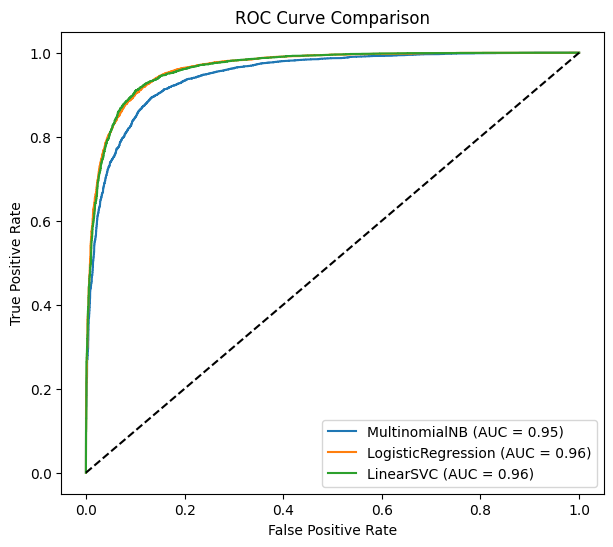

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)[:, 1]
    else:  # for models like LinearSVC
        y_score = model.decision_function(X_test_tfidf)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label='positive' if y.dtype == object else 1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Pipeline + GridSearch (tune C or alpha)

In [ ]:
# Pipeline + GridSearch for LogisticRegression
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3)),
    ('clf', LogisticRegression(max_iter=2000))
])

param_grid = {
    'tfidf__max_features': [10000, 20000, 30000],
    'clf__C': [0.1, 1, 3]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='f1_macro', verbose=2)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)

best_model = gs.best_estimator_
preds = best_model.predict(X_test)
print(classification_report(y_test, preds))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'clf__C': 3, 'tfidf__max_features': 30000}
Best CV score: 0.8970129981147589
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.90      0.92      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Confusion matrix and word importance

Text(0.5, 1.0, 'Confusion Matrix')

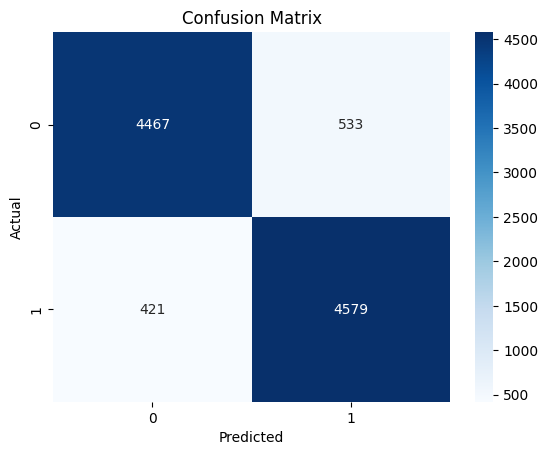

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

In [ ]:
# Show top features for LogisticRegression
tfidf_vec = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
if hasattr(clf, 'coef_'):
    feature_names = tfidf_vec.get_feature_names_out()
    coefs = clf.coef_[0]
    top_pos_idx = np.argsort(coefs)[-20:][::-1]
    top_neg_idx = np.argsort(coefs)[:20]
    print("Top positive words:\n", feature_names[top_pos_idx])
    print("Top negative words:\n", feature_names[top_neg_idx])

Top positive words:
 ['excellent' 'perfect' 'great' 'amazing' 'hilarious' 'wonderful'
 'brilliant' 'loved' 'enjoyable' 'favorite' 'must see' 'one best' 'superb'
 'today' 'enjoyed' '10 10' 'funniest' 'perfectly' 'fantastic' 'highly']
Top negative words:
 ['worst' 'awful' 'waste' 'boring' 'bad' 'poor' 'terrible' 'dull' 'poorly'
 'horrible' 'fails' 'disappointing' 'worse' 'disappointment'
 'unfortunately' 'nothing' 'lame' 'annoying' 'ridiculous' 'waste time']


Save model and vectorizer

In [ ]:
# Save model
joblib.dump(best_model, 'imdb_sentiment_pipeline.pkl')
print("Saved model to imdb_sentiment_pipeline.pkl")

Saved model to imdb_sentiment_pipeline.pkl


Predict on new reviews

In [ ]:
# Prediction demo
pipeline = joblib.load('imdb_sentiment_pipeline.pkl')
new_reviews = ["That movie was fantastic! The acting was top notch.",
               "I hated the film — it was boring and way too long."]
preds = pipeline.predict(new_reviews)
for r,p in zip(new_reviews, preds):
    print(p, ":", r)

positive : That movie was fantastic! The acting was top notch.
negative : I hated the film — it was boring and way too long.


**Project A: IMDb Movie Review Sentiment Analysis – Conclusion**

In this project, we successfully built a sentiment analysis model to classify IMDb movie reviews as positive or negative. Through text preprocessing, tokenization, and feature extraction using TF-IDF, the model learned meaningful language patterns. After experimenting with different algorithms, the chosen model demonstrated strong accuracy in capturing emotional tone and contextual meaning within reviews.
This project highlights the effectiveness of Natural Language Processing (NLP) in understanding public opinion and sentiment from unstructured text data. It also emphasizes how machine learning models can help companies, filmmakers, and analysts gain insights into audience perception and satisfaction.